# Heart Disease Predictor (Artificial Neural Networks - ANNs)

### 1) Import Libraries 

In [4]:
# Import libraries and modules

#----- Tools, visualizers -----
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import skewness_detector, outlier_detector

#----- Preprocessing, Neural Networks -----
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, \
    StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import tensorflow as tf


### 2) Load Data

In [5]:
# Load dataset
#---------------
data = pd.read_csv("..\Data\heart-data.csv")
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


### 3) Split Data
Before preprocessing and model training, we need to split the dataset into **train** and **validation** sets.  
- The **training set** is used to learn the patterns.  
- The **validation set** is used to evaluate performance on unseen data, preventing overfitting.  

In [6]:
# Split dataset into train and validation sets
#----------------------------------------------

# Set random state
RANDOM_STATE = 42

# Separate features and labels cols
X = data.drop(columns='HeartDisease') # Features
y = data['HeartDisease'] # Labels

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15 , random_state=RANDOM_STATE, stratify=y
)

print("----Done----")

----Done----


### Preprocessing
Preprocessing ensures that the dataset is clean, consistent, and suitable for Neural Networks.  
In this project, our preprocessing will focus on:  
1. **Handling invalid values**  
   - *RestingBP*: drop rows with 0 (impossible value).  
   - *OldPeak*: replace negative values with 0 (invalid in medical context).  
   - *Cholesterol*: treat 0 as missing values and impute instead of dropping (since there are many).  

2. **Imputation**  
   - For *Cholesterol*, we will impute missing/invalid values.  
   - Options: Mean, Median, or Model-based imputation.  
   - For this project, we will start simple (Median/Mean) then we can test Model-based imputations to compare performance.  

3. **Scaling / Standardization**  
   - Many ML models (e.g., Logistic Regression, SVM, KNN) require features to be on similar scales.  
   - We will apply **StandardScaler** or **MinMaxScaler** depending on the model. 
        - For ANNs we need to scale the values in a specific range (e.g. [0,1]), **MinMaxScaler** is the ideal choice in this case.
 
4. **Encoding categorical features**  
   - Convert categorical variables into numeric form using **One-Hot Encoding** or **Label Encoding** depending on the situation.  

5. *(Optional)* Handling skewness and outliers  
   - For this project, we will skip skewness/outlier handling, since:  
     - Skewness may only affect specific models.  
     - Outliers in medical datasets may represent real patients and should not always be removed.  
 
6. *(Optional)* Convert dataframes into numpy arrays to be fed into the networks.


---


### 4) Core of preprocessing and handling data
> Including 3-5 steps mentioned above.

- ##### 1) Handling missing values & Imputation


In [7]:
"""
Three continuous numeric features were spotted having INVALID,
 IMPOSSIBLE vlues BIOLOGICLY & in terms of MEDICAL SCIENCE
 * RestingBP -> 1 case with the value 0 (since it's only one case it's better to be removed)
 * OldPeak -> 13 cases with negative values (there are atleast two ways to consider)
    - Replacing negative values with the baseline which is 0 (clipping)
    - Using median imputation
    -> First option is reasonable since number of cases is low
 * Cholesterol -> 172 cases with the value 0 (almost 20% of values)
 - Zeros can be considered as missing values and be imputed by using median/mean or Model-based techniques

"""


# 1. RestingBP preprocessing
#-----------------------------

# Set masks: Keep all rows except the one that's 0
mask_t = X_train['RestingBP'] != 0
mask_v = X_val['RestingBP'] != 0

#  Train
#--------------
# Filter X_train
X_train = X_train[mask_t].reset_index(drop=True)

# Filter y_train
y_train = y_train[mask_t].reset_index(drop=True)

#  Validation
#---------------
# Filter X_val
X_val = X_val[mask_v].reset_index(drop=True)

# Filter y_val
y_val = y_val[mask_v].reset_index(drop=True)


# 2. OldPeak preprocessing
#-----------------------------

# Filter X_train
X_train['Oldpeak'] = X_train['Oldpeak'].apply(lambda x: 0 if x < 0 else x)

# Filter X_val
X_val['Oldpeak'] = X_val['Oldpeak'].apply(lambda x: 0 if x < 0 else x)

# -> Alternative: np.clip()

# 3. Choleterol preprocessing
#-----------------------------

# Median imputation
#-------------------

# Convert zeros into Nan
X_train['Cholesterol'] = X_train['Cholesterol'].replace(0, np.nan)
X_val['Cholesterol'] = X_val['Cholesterol'].replace(0, np.nan)

# Define median imputer
median_imputer = SimpleImputer(strategy='median')

# Apply on X_train
X_train['Cholesterol'] = median_imputer.fit_transform(X_train[['Cholesterol']])

# Apply on X_val
X_val['Cholesterol'] = median_imputer.transform(X_val[['Cholesterol']])

print("----Preprocessing Done----")

----Preprocessing Done----


In [8]:
# Check outliers of X_train after preprocessing to decide which scaler to use
# Safe zone -> outliers < 5%

f = X_train[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']]
outlier_detector(f)



,feature,n_outliers,outlier_pct
2,Cholesterol,35,4.493
1,RestingBP,23,2.953
4,Oldpeak,12,1.540
3,MaxHR,1,0.128
0,Age,0,0.000


> what remained as outliers are rare but valid observations.
> These aren’t “outliers” in the sense of “bad data,” they’re just part of the true distribution of your population.

In [9]:
# Check skewness of X_train after preprocessing
f = X_train[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']]
skewness_detector(f) 

,Feature,Skewness,Exceeding_Threshold
0,Age,0.218176,False
1,RestingBP,0.617980,False
2,Cholesterol,1.493441,True
3,MaxHR,0.163001,False
4,Oldpeak,1.100429,True


- ##### 2) Scaling / Standardization

In [10]:
"""
Continuous numeric features should be scaled and standardized
* Including Features: [Age, RestingBP, Cholesterol, MaxHR, Oldpeak]
* The ideal option for scaling technique is `MinMaxScaler`
"""

# Specify continuous numeric features
con_num_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Define MinMaxScaler
mm_scaler = MinMaxScaler()

#  Train
#--------------
X_train_scaled = pd.DataFrame(
    mm_scaler.fit_transform(X_train[con_num_features]),
    columns=con_num_features,
    index=X_train.index
    )

#  Validation
#--------------
X_val_scaled = pd.DataFrame(
    mm_scaler.transform(X_val[con_num_features]),
    columns=con_num_features,
    index=X_val.index
    )


print("----Scaling & Standardizing Done----")
print("X_train_scaled check:")
print(X_train_scaled.head())
print("X_val_scaled check:")
print(X_val_scaled.head())

----Scaling & Standardizing Done----
X_train_scaled check:
        Age  RestingBP  Cholesterol     MaxHR   Oldpeak
0  0.291667   0.433333     0.312741  0.584507  0.017857
1  0.812500   0.316667     0.370656  0.640845  0.178571
2  0.583333   0.433333     0.235521  0.760563  0.000000
3  0.645833   0.416667     0.233591  0.507042  0.428571
4  0.437500   0.666667     0.293436  0.352113  0.000000
X_val_scaled check:
        Age  RestingBP  Cholesterol     MaxHR   Oldpeak
0  0.458333   0.375000     0.198842  0.598592  0.000000
1  0.854167   0.416667     0.457529  0.345070  0.428571
2  0.187500   0.250000     0.293436  0.676056  0.000000
3  0.333333   0.483333     0.291506  0.647887  0.035714
4  0.375000   0.233333     0.305019  0.647887  0.000000


- #### 3) Encoding categorical features


In [40]:
"""
Categorical features that aren't numeric type should be encoded to
numerical types.
* Including Features: [Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope]
* `FastingBS` was excluded since it's already numeric (binary: 0s 1s)
* The encoders could be used are:
- Label Encoding -> For binary categories
- One-Hot Encoding -> For nominal (no order) or Ordinal (ordered) categories
- Ordinal Encoding -> For ordinal (ordered) categories
* In our case for the features, all of encoders can be used for the corresponding categories:
- Sex, ExerciseAngina (Binary) => Label Encoder
- ChestPainType, RestingECG (Nominal) => One-Hot Encoder
- ST_Slope (Ordinal) => Ordinal  or One-Hot Encoding
"""

# Specify categorical features
bin_features = ['Sex', 'ExerciseAngina']
nom_features = ['ChestPainType', 'RestingECG']
ord_features = ['ST_Slope']

# Define encoders
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ore = OrdinalEncoder(categories=[['Down', 'Flat', 'Up']]) 


#-------------
# Train
#-------------

# Label encoding 
X_train_bin_encoded = pd.DataFrame(
    {col: LabelEncoder().fit_transform(X_train[col]) for col in bin_features},
    index=X_train.index
)

# One-hot encoding
X_train_nom_encoded = pd.DataFrame(
    ohe.fit_transform(X_train[nom_features]),
    columns=ohe.get_feature_names_out(nom_features),
    index=X_train.index
)

# Ordinal encoding 
X_train_ord_encoded = pd.DataFrame(
    ore.fit_transform(X_train[ord_features]),
    columns=ord_features,
    index=X_train.index
)


#-------------
# Validation
#-------------

# Label encoding 
X_val_bin_encoded = pd.DataFrame(
    {col: LabelEncoder().fit(X_train[col]).transform(X_val[col]) for col in bin_features},
    index=X_val.index
)

# One-hot encoding
X_val_nom_encoded = pd.DataFrame(
    ohe.transform(X_val[nom_features]),
    columns=ohe.get_feature_names_out(nom_features),
    index=X_val.index
)

# Ordinal encoding 
X_val_ord_encoded = pd.DataFrame(
    ore.transform(X_val[ord_features]),
    columns=ord_features,
    index=X_val.index
)


#-------------
# Concatenate
#-------------

final_X_train = pd.concat([
    X_train['FastingBS'],
    X_train_bin_encoded,
    X_train_nom_encoded, 
    X_train_ord_encoded,
    X_train_scaled], axis=1)


final_X_val = pd.concat([
    X_val['FastingBS'],
    X_val_bin_encoded,
    X_val_nom_encoded, 
    X_val_ord_encoded,
    X_val_scaled], axis=1)


print("----Encoding Done----")
print("final_X_train check:")
final_X_train

----Encoding Done----
final_X_train check:


,FastingBS,Sex,ExerciseAngina,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,1,1,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.291667,0.433333,0.312741,0.584507,0.017857
1,0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.812500,0.316667,0.370656,0.640845,0.178571
2,0,1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.583333,0.433333,0.235521,0.760563,0.000000
3,0,1,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.645833,0.416667,0.233591,0.507042,0.428571
4,1,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.437500,0.666667,0.293436,0.352113,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.354167,0.333333,0.279923,0.633803,0.000000
775,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.875000,0.416667,0.262548,0.387324,0.000000
776,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.666667,0.450000,0.293436,0.183099,0.267857
777,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.666667,0.375000,0.399614,0.387324,0.000000


- #### 4) Convert dataframes into numpy arrays

In [ ]:
#--------------------------------------
# Convert dataframes into numpy arrays
#--------------------------------------

final_X_train = final_X_train.to_numpy()
final_X_val = final_X_val.to_numpy()

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

print("----Done----")

----Done----


In [30]:
# Get the shapes
shape = final_X_train.shape
print(f"Shape of final_X_train: {shape}\nShape of inputs: ({shape[1]},)")

Shape of final_X_train: (779, 16)
Shape of inputs: (16,)


### 5) Build the architecture and model

In [31]:
#--------------------------------------------------------
# Build the architecture, model and fit, train, evaluate
#--------------------------------------------------------

# Create neural networks architecture 
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(shape=(16,)),
    # First hidden layer with 16 units
    tf.keras.layers.Dense(16, activation='relu'),
    # Second hidden layer with 8 units 
    tf.keras.layers.Dense(8, activation='relu'),
    # Set dropout to prevent overfitting
    tf.keras.layers.Dropout(0.3),
    # Third hidden layer with 1 unit (output layer)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Stop early if validation loss doesn’t improve for 5 epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=5,
                                                restore_best_weights=True
                                                )

# Fit
history = model.fit(
    final_X_train,
    y_train,
    epochs=30,
    validation_data=(final_X_val, y_val),
    callbacks=[early_stop]
)

# Evaluate during training
model.evaluate(final_X_val, y_val, verbose=2)



Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4737 - loss: 0.8087 - val_accuracy: 0.5580 - val_loss: 0.6824
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5866 - loss: 0.6589 - val_accuracy: 0.7101 - val_loss: 0.6145
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7047 - loss: 0.6039 - val_accuracy: 0.7899 - val_loss: 0.5647
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7497 - loss: 0.5600 - val_accuracy: 0.8261 - val_loss: 0.5238
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7535 - loss: 0.5356 - val_accuracy: 0.8551 - val_loss: 0.4853
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7805 - loss: 0.5020 - val_accuracy: 0.8551 - val_loss: 0.4551
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7843 - loss: 0.4919 - val_accuracy: 0.8768 - val_loss: 0.4296
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8216 - loss: 0.4680 - val_accuracy: 0.8768 - val_loss

[0.34812411665916443, 0.8623188138008118]

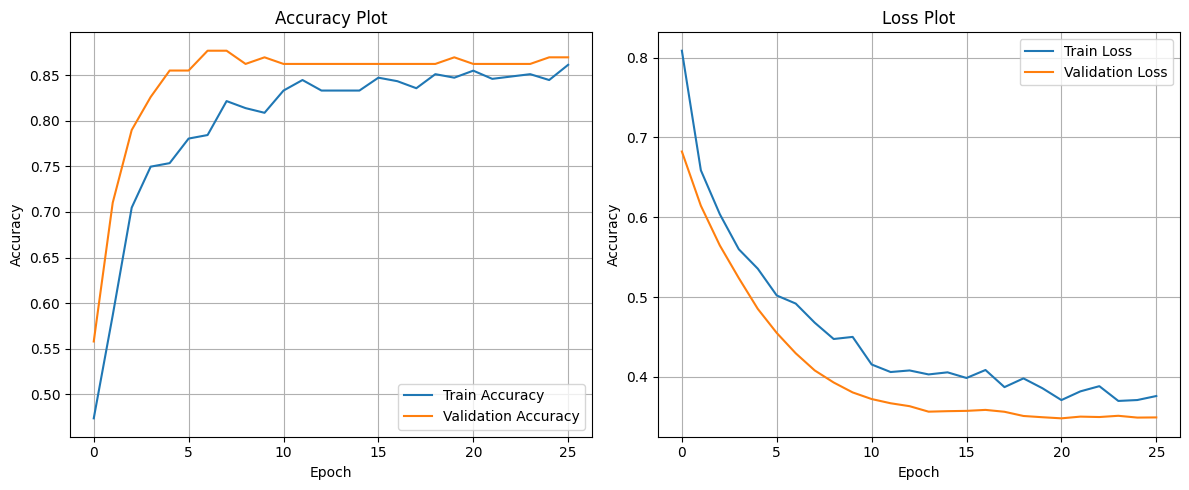

In [32]:
#-------------------------------------
# Visualize performance of the model
#-------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
axes[0].plot(history.history['accuracy'], label="Train Accuracy")
axes[0].plot(history.history['val_accuracy'], label="Validation Accuracy")
axes[0].set_title("Accuracy Plot")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid()
axes[0].legend()

# Loss comparison
axes[1].plot(history.history['loss'], label="Train Loss")
axes[1].plot(history.history['val_loss'], label="Validation Loss")
axes[1].set_title("Loss Plot")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
F1-Score (weighted): 86.906 %
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        62
           1       0.86      0.91      0.88        76

    accuracy                           0.87       138
   macro avg       0.87      0.87      0.87       138
weighted avg       0.87      0.87      0.87       138



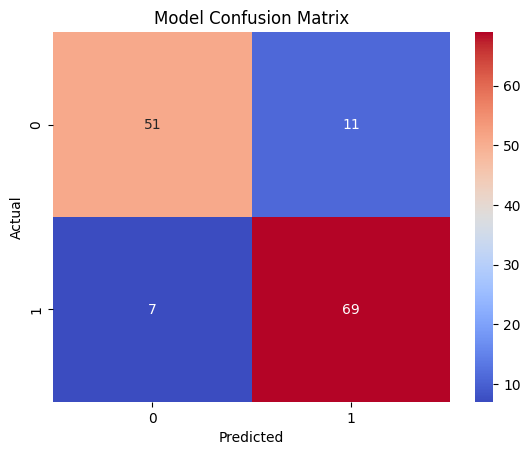

In [38]:
#----------------------------------------------
# More detailed evaluation on validation set
#----------------------------------------------

# Predict
y_pred_probs = model.predict(final_X_val) # Outputs are probabilities which is between 0 & 1

# For evaluation with below metrics probs need to be converted into binary labels 0 or 1, So:
# Convert probabilities into binary labels
y_pred = (y_pred_probs > 0.45).astype("int32").flatten()

# Evaluate 
# F1-score
print(f"F1-Score (weighted): {round(f1_score(y_val, y_pred, average='weighted') * 100, 3)} %")
# Classification report
print(f"Classification Report:\n{classification_report(y_val, y_pred)}")
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Visualize confusion matrix
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.title("Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [39]:
#----------------
# Save the model
#----------------

model.save("../Models/ANN_model.keras")

print("Model Saved: ANN_model.keras")

Model Saved: ANN_model.keras
